# Work starting on January 19th: Part 1

1. Just have the defocus (and no aberration) <br>
    a. How does the performance vary with number of iterations? <br>
    b. How does the performance vary with learning rate? <br>
    c. How does the performance vary with loss multiplier? <br>
    d. How does the performance vary with optimizer?
        i. Research what SGD and Adam optimizers are.
        ii. What are the benefits of Adam over SGD? In what cases are which more or less appropriate?
    e. How does the performance vary with different starting values of defocus? <br>
        i. Research what is typical uncertainty in the defocus value.

2. Just take one aberration (spherical aberration) into account. Repeat above steps. <br>
   Also track what happens to the aberration values- should tend towards the GT (0).

3. Add some noise to the reference image. <br>
    Generate image and add noise using the Demos/HRTEM.py program.

4. Simulate a molecule instead of a crystal. <br>
    
While examining, collect the resultant images.    

While examining, look at the gradients.
The gradient if starting at a defocus of 200 (the ground truth) should be zero.

In [2]:
import pyms
import numpy as np
import torch
import time
from pyms.Probe import aberration
from copy import deepcopy
import matplotlib.pyplot as plt

from pyms.utils.torch_utils import (
    amplitude,
    crop_to_bandwidth_limit_torch,
    size_of_bandwidth_limited_array,
    amplitude,
)

from pyms.Probe import (
    make_contrast_transfer_function,
)

%matplotlib inline

#crystal = pyms.structure.fromfile(
#    "Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
#)

crystal = pyms.structure.fromfile(
    "/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/Demos/Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic structure
crystal = crystal.resize([0.1, 0.76], axis=0)

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])


In [3]:
# Establish aberrations
# Just defocus for now

def establish_aberrations():
    """Create a list of aberrations. Initialise with starting values."""

    aberrations = []

    # Initial guesses for aberrations
    df = 175.0

    # Krivanek aberration coefficient, Haider aberration coefficient, colloquial name, amplitude, angle, n, m
    # n and m are constants (shouldn't be differentiable), amplitude and angle should be

    aberrations.append(aberration("C10", "C1", "Defocus          ", torch.tensor([df], requires_grad = True), 0.0, 1, 0.0))
    
    return aberrations


In [4]:
# Set up our initial guess for the crystal HRTEM
# It uses the aberrations (including defocus) as set above

def create_initial_guess(aberrations):

    output = pyms.HRTEM(
        crystal,
        gridshape,
        eV,
        app,
        thicknesses,
        subslices=subslices,
        aberrations=aberrations,
        df= aberrations[0].amplitude,
        tiling=tiling,
        nfph=1,
        showProgress='notebook', 
        apply_ctf = False,
    )
    #plt.imshow(torch.abs(output).detach().cpu().numpy(), vmax = 10)
    
    return output

In [13]:
def save_sim_image(sim_image, optimizer):
    plt.imshow(sim_image[0].detach().cpu().numpy())

    plt.title(u'Simulated image of SrTiO\u2083\n with {optimizer} optimizer'.format(optimizer=optimizer), fontsize=15)
    plt.xticks([])
    plt.yticks([])

    filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Optimizer/simulated_image_"+ str(optimizer) + ".jpg"
    plt.savefig(filepath, dpi=500)
    print("Saved")

In [5]:
def optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    # Generic form allows more flexibility if we decided to not include some aberrations in the future.
    for i in range(0, len(aberrations)):
        params.append(aberrations[i].amplitude)
        curves.append([])

    optimizer = torch.optim.Adam(params, lr = learning_rate)
    criterion = torch.nn.MSELoss()

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu') # changed cuda to cpu
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()

        loss = criterion(sim_image, ref_data)*loss_multiplier

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())


        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()
    
    runtime = end-start
    
    save_sim_image(sim_image, "Adam")
    
    return runtime, loss.item(), aberrations[0].amplitude.item()

    #print("Time to run:", str((end - start)))
    #print("Loss", str(loss.item())) # Final loss value
    #print("Final defocus value", str(aberrations[0].amplitude.item()))

In [11]:
def optimise_SGD(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    # Generic form allows more flexibility if we decided to not include some aberrations in the future.
    for i in range(0, len(aberrations)):
        params.append(aberrations[i].amplitude)
        curves.append([])

    optimizer = torch.optim.SGD(params, lr = learning_rate, momentum=0.9)
    criterion = torch.nn.MSELoss()

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu') # changed cuda to cpu
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()

        loss = criterion(sim_image, ref_data)*loss_multiplier

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())


        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()
    
    runtime = end-start
    
    save_sim_image(sim_image, "SGD")
    
    return runtime, loss.item(), aberrations[0].amplitude.item()

    #print("Time to run:", str((end - start)))
    #print("Loss", str(loss.item())) # Final loss value
    #print("Final defocus value", str(aberrations[0].amplitude.item()))

In [7]:
def main(n_iters, learning_rate, loss_multiplier):
    aberrations = establish_aberrations()
    output = create_initial_guess(aberrations)
    
    # Load in "experimental" data
    path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'
    ref_data = np.load(path)
    ref_data = torch.tensor(ref_data).to('cpu')
    
    runtime, loss, defocus_final = optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier)
    return runtime, loss, defocus_final
    
    

In [10]:
def main_SGD(n_iters, learning_rate, loss_multiplier):
    aberrations = establish_aberrations()
    output = create_initial_guess(aberrations)
    
    # Load in "experimental" data
    path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'
    ref_data = np.load(path)
    ref_data = torch.tensor(ref_data).to('cpu')
    
    runtime, loss, defocus_final = optimise_SGD(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier)
    return runtime, loss, defocus_final
    
    

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

1


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
115.76233983039856
0.0011727682438731452
175.03045654296875


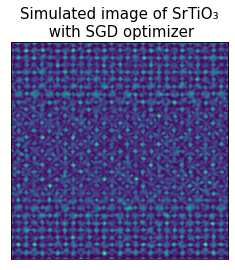

In [14]:
runtime, loss, defocus_final = main_SGD(2000, 1e-1, 1e9)
print(runtime)
print(loss)
print(defocus_final)

In [ ]:
# Also should we check how the performance of the SDG varies with different momentum values?

In [ ]:
# Run using SGD instead of Adam
# Need to read into SGD and what parameters it needs

# Should I do all the looping again for SGD? (skull)



        params (iterable) – iterable of parameters to optimize or dicts defining parameter groups

        lr (float) – learning rate

        momentum (float, optional) – momentum factor (default: 0)

        weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)

        dampening (float, optional) – dampening for momentum (default: 0)

        nesterov (bool, optional) – enables Nesterov momentum (default: False)

        maximize (bool, optional) – maximize the params based on the objective, instead of minimizing (default: False)

        foreach (bool, optional) – whether foreach implementation of optimizer is used. If unspecified by the user (so foreach is None), we will try to use foreach over the for-loop implementation on CUDA, since it is usually significantly more performant. Note that the foreach implementation uses ~ sizeof(params) more peak memory than the for-loop version due to the intermediates being a tensorlist vs just one tensor. If memory is prohibitive, batch fewer parameters through the optimizer at a time or switch this flag to False (default: None)

        differentiable (bool, optional) – whether autograd should occur through the optimizer step in training. Otherwise, the step() function runs in a torch.no_grad() context. Setting to True can impair performance, so leave it False if you don’t intend to run autograd through this instance (default: False)



https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

In [ ]:
# Example code

SGD_model = torch.nn.Sequential(
    torch.nn.Linear(dim_in, dim_h),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_h, dim_out),
)

loss_fn = torch.nn.MSELoss(reduction='sum')

rate_learning = 0.1

optim = torch.optim.SGD(SGD_model.parameters(), lr=rate_learning, momentum=0.9)

for values in range(500):
    pred_y = SGD_model(input_X)
    loss = loss_fn(pred_y, output_Y)
    if values % 100 == 99:
        print(values, loss.item())

In [ ]:
plt.plot(n_iterations, losses)
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Variation_with_iterations/Loss.jpg"
plt.savefig(filepath, dpi=500)

plt.show()

In [ ]:
plt.plot(n_iterations, defocus_values)
plt.ylabel('Final defocus value')
plt.xlabel('Number of iterations')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Variation_with_iterations/Defocus.jpg"
plt.savefig(filepath, dpi=500)

plt.show()

In [ ]:
y_data = [x-100 for x in defocus_values]

plt.plot(n_iterations, y_data)
plt.ylabel('Difference in defocus value from ground truth')
plt.xlabel('Number of iterations')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_1_just_df/Variation_with_iterations/Defocus-change.jpg"
plt.savefig(filepath, dpi=500)

plt.show()